# Assignment 5

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task.


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [ ]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters

# feel free to import other libraries as needed

import warnings
warnings.filterwarnings('ignore')

### Define functions

In [ ]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )

    return df

In [ ]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15

    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [ ]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What are the unique cocoa_percent values?

In [ ]:
print("The dataset contains 9 columns.")
print("The dataset contains 1795 rows.")
print("The column names are: ", list(df.columns))
print("The number of unique values for each column is: ", df.nunique())
print("The unique cocoa_percent values are: ", df['cocoa_percent'].nunique())

The dataset contains 9 columns.
The dataset contains 1795 rows.
The column names are:  ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']
The number of unique values for each column is:  maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64
The unique cocoa_percent values are:  45


### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you’ve explored the data, choose a multiclass outcome (anything except "ratings") that you’re interested in predicting. Note: The outcome should have <span style="color:chocolate">at least 3 classes</span>!

If your chosen outcome variable requires preprocessing, go ahead and handle that below. For instance, you might choose to predict "cocoa_percent". Discretizing it into "0=low," "1=medium," and "2=high" makes it easier to work with/interpret the results.

Your answer here:

In [ ]:
print("My chosen variable was cocoa_percent and I classified it into low, medium, and high as 0,1,2.")
df.loc[df['cocoa_percent'] <= 69, 'cocoa_percent'] = 0
df.loc[(df['cocoa_percent'] > 69) & (df['cocoa_percent'] <= 72), 'cocoa_percent'] = 1
df.loc[df['cocoa_percent'] > 72, 'cocoa_percent'] = 2
print(df['cocoa_percent'])

My chosen variable was cocoa_percent and I classified it into low, medium, and high as 0,1,2.
0      0.00
1      1.00
2      1.00
3      1.00
4      1.00
       ... 
1790   1.00
1791   0.00
1792   0.00
1793   0.00
1794   0.00
Name: cocoa_percent, Length: 1795, dtype: float64


---
### Step 2: Data preprocessing

### <span style="color:chocolate">Exercise 3:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Shuffle the dataset;
2. Create training, validation, and test datasets using a 60/20/20 split;
3. Identify the features of interest;
4. Perform necessary cleaning and standarization on the features.

In [ ]:
np.random.seed(0)
#reordering indeces
indeces = df['cocoa_percent'].index.to_numpy()
shuffled_indeces = np.random.permutation(indeces)
shuffled_data = df.reindex(shuffled_indeces)
Y = shuffled_data['cocoa_percent']
X = shuffled_data.drop(columns=['cocoa_percent'])
#splitting the data
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=1234)
print(Y_train)
#features of interest
features_of_interest = ['reference_number', 'review_date', 'rating', 'bean_type']
X_train = X_train[features_of_interest]
X_val = X_val[features_of_interest]
X_test = X_test[features_of_interest]
#convert bean type to one-hot representation, and then to single integer based on 1 index
bean_train_onehot = pd.get_dummies(X_train['bean_type'])
bean_categories = bean_train_onehot.columns
X_train['bean_type'] = np.argmax(bean_train_onehot.values, axis=1)
bean_val_onehot = pd.get_dummies(X_val['bean_type'])
X_val['bean_type'] = np.argmax(bean_val_onehot.values, axis=1)
bean_test_onehot = pd.get_dummies(X_test['bean_type'])
X_test['bean_type'] = np.argmax(bean_test_onehot.values, axis=1)
#standardization for inputs only numeric columns
numeric_features = ['reference_number', 'review_date', 'rating']
X_train[numeric_features] = (X_train[numeric_features] - X_train[numeric_features].mean()) / X_train[numeric_features].std()
X_val[numeric_features]   = (X_val[numeric_features] - X_train[numeric_features].mean()) / X_train[numeric_features].std()
X_test[numeric_features]  = (X_test[numeric_features] - X_train[numeric_features].mean()) / X_train[numeric_features].std()

883    1.00
1307   1.00
156    2.00
38     2.00
1501   1.00
       ... 
1595   2.00
664    1.00
1070   2.00
1062   0.00
548    2.00
Name: cocoa_percent, Length: 1077, dtype: float64


---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 4:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features and outcome within the training dataset;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

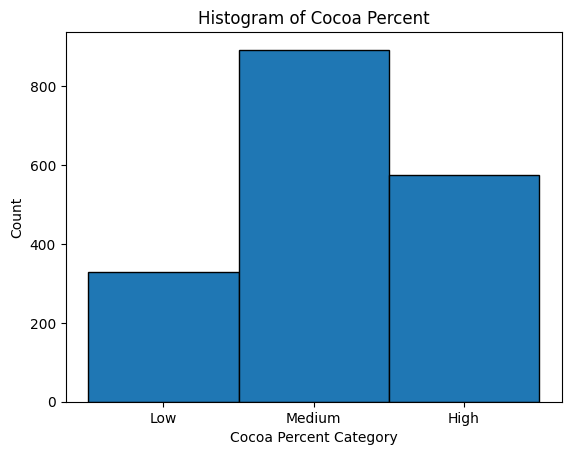

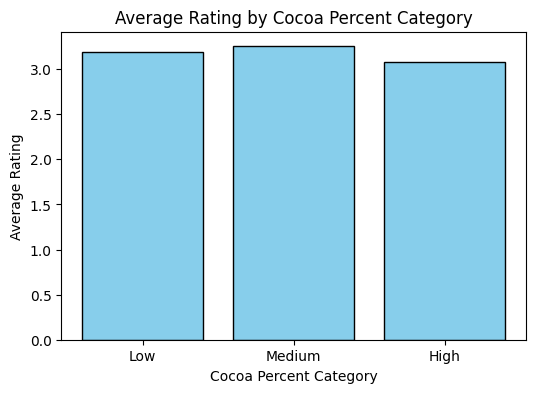

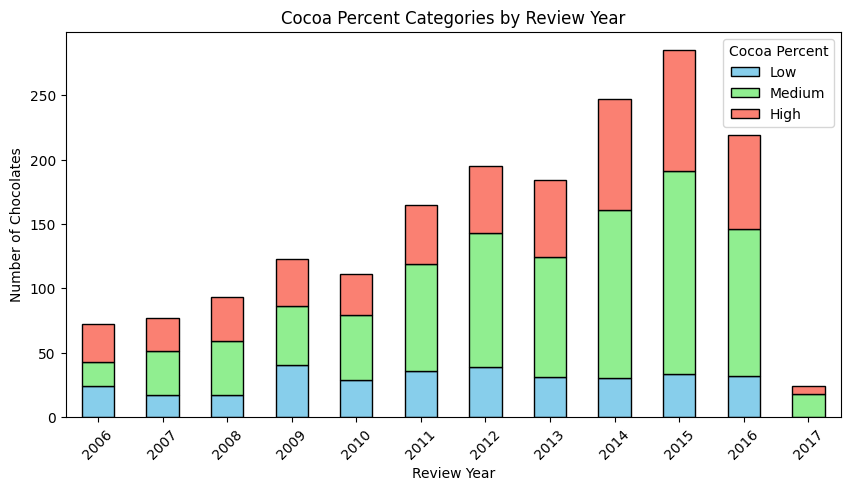

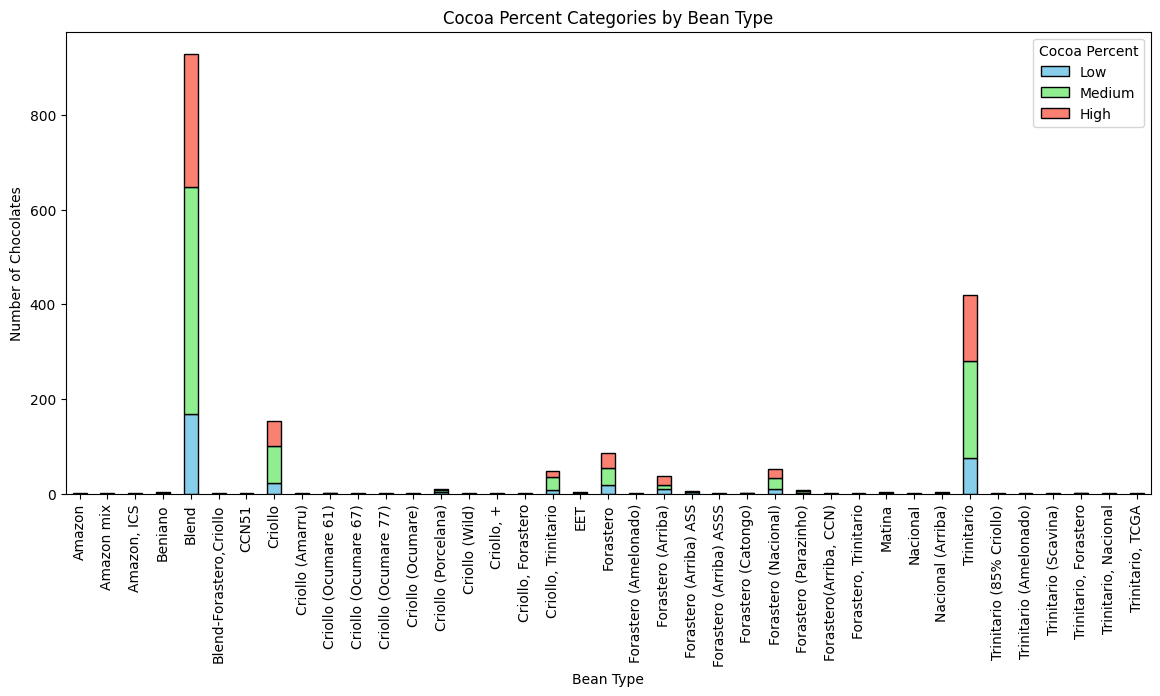

The cocoa percent of the chocolates fall mostly in the medium category between 69 and 72 percent.
The average rating for all chocolates in cacao categories is around 3.0.
Years which sold the most chocolates appear to have sold more medium cacao chocolates than other types.
The blended bean type is the most sold.


In [ ]:
plt.hist(df['cocoa_percent'], bins=[-0.5, 0.5, 1.5, 2.5], edgecolor='black')
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.xlabel('Cocoa Percent Category')
plt.ylabel('Count')
plt.title('Histogram of Cocoa Percent')
plt.show()

avg_rating = df.groupby('cocoa_percent')['rating'].mean()
plt.figure(figsize=(6,4))
plt.bar(avg_rating.index, avg_rating.values, color='skyblue', edgecolor='black')
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.xlabel('Cocoa Percent Category')
plt.ylabel('Average Rating')
plt.title('Average Rating by Cocoa Percent Category')
plt.show()

counts = pd.crosstab(df['review_date'], df['cocoa_percent'])
counts.plot(kind='bar', stacked=True, figsize=(10,5), color=['skyblue','lightgreen','salmon'], edgecolor='black')
plt.xlabel('Review Year')
plt.ylabel('Number of Chocolates')
plt.title('Cocoa Percent Categories by Review Year')
plt.xticks(rotation=45)
plt.legend(['Low', 'Medium', 'High'], title='Cocoa Percent')
plt.show()

counts1 = pd.crosstab(df['bean_type'], df['cocoa_percent'])
counts1.plot(kind='bar', stacked=True, figsize=(14,6), color=['skyblue','lightgreen','salmon'], edgecolor='black')
plt.xlabel('Bean Type')
plt.ylabel('Number of Chocolates')
plt.title('Cocoa Percent Categories by Bean Type')
plt.xticks(rotation=90)
plt.legend(['Low', 'Medium', 'High'], title='Cocoa Percent')
plt.show()

print("The cocoa percent of the chocolates fall mostly in the medium category between 69 and 72 percent.")
print("The average rating for all chocolates in cacao categories is around 3.0.")
print("Years which sold the most chocolates appear to have sold more medium cacao chocolates than other types.")
print("The blended bean type is the most sold.")

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 5:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [ ]:
def ce_loss(preds, Y):
  """
    preds are (m,n) m = number of examples, n = number of classes
    Y is (m,) -- array of sparse labels
    preds[0] = [.1, .1, .8] Y[0] = 2 Y_dense[0] = [0, 0, 1]
  """
  # Get the number of examples
  m = Y.shape[0]

  # Compute the first sum, the cross-entropy for each example, using
  # the rows of the predictions and corresponding labels.
  # Note that we need the dense (one-hot) labels.
  Y_dense = tf.keras.utils.to_categorical(Y)
  # [.1, .1, .8] [0, 0, 1] -> [0, 0, -1*log(.8)] -> -1*log(.8)
  cross_entropy_values = - np.sum(Y_dense * np.log(preds), axis=1)

  # Here's a more efficient but tricky way to do this:
  # cross_entropy_values = -np.log(preds[range(m), Y])

  # Sum the per-example cross-entropy values.
  loss = np.sum(cross_entropy_values) / m

  return loss

# Remember the sigmoid function.
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# Our softmax function will normalize over the rows of the input matrix.
def softmax(z):
  """z has shape (m, n): examples, classes"""
  (m, n) = z.shape

  # First exponentiate each value
  exps = np.exp(z)

  # Get the sum of each row and normalize
  row_sums = np.sum(exps, axis=1)
  for i in range(m):
    exps[i,:] /= row_sums[i]

  # Fancy/tricky way to do row-wise sums in numpy:
  # return np.divide(exps.T, np.sum(exps, axis=1)).T

  return exps

#baselines
num_classes = len(np.unique(Y_train))
majority_class = np.bincount(Y_train).argmax()
logits_train = np.zeros((Y_train.shape[0], num_classes))
logits_val   = np.zeros((Y_val.shape[0], num_classes))
logits_train[:, majority_class] = 1
logits_val[:, majority_class] = 1
Y_train_baseline_probs = softmax(logits_train)
Y_val_baseline_probs   = softmax(logits_val)
#calculating accuracy
accuracy = (majority_class == Y_train).sum()/len(Y_train)
print("The accuracy is: ", accuracy)
print("The accuracy of the baseline is equal to the total in the majority class divided by the total in the training dataset.")
print("This is because the baseline has been initialized to only the majority class, and will therefore only be correct when the training dataset is also the majority class.")
#calculate loss on train data
print("Loss on Training Data with Baseline: " , ce_loss(Y_train_baseline_probs, Y_train))
print("Loss on Validation Data with Baseline: " , ce_loss(Y_val_baseline_probs, Y_val))

print("There are only 3 classes: 0,1,2. Of these 3, 1 was the majority. That is why the loss is minimized. The baseline is all 1, and the rest only have a difference of 1.")


The accuracy is:  0.49396471680594245
The accuracy of the baseline is equal to the total in the majority class divided by the total in the training dataset.
This is because the baseline has been initialized to only the majority class, and will therefore only be correct when the training dataset is also the majority class.
Loss on Training Data with Baseline:  1.0574799971261086
Loss on Validation Data with Baseline:  1.038909894990547
There are only 3 classes: 0,1,2. Of these 3, 1 was the majority. That is why the loss is minimized. The baseline is all 1, and the rest only have a difference of 1.


### <span style="color:chocolate">Exercise 6:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001 and optimizer = SGD.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0943 - val_loss: 1.0044
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0826 - val_loss: 1.0810
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0740 - val_loss: 1.2593
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0693 - val_loss: 1.4914
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0769 - val_loss: 1.7467
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0637 - val_loss: 2.0192
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0659 - val_loss: 2.3118
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0644 - val_loss: 2.6150
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0570 - val_loss: 2.9245
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0661 - val_loss: 3.2193


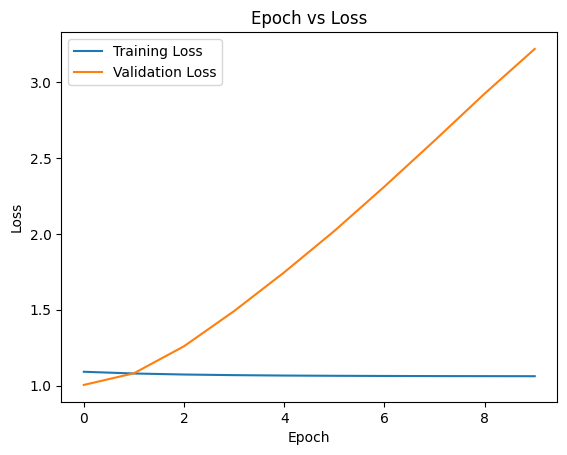

In [ ]:
tf.keras.backend.clear_session()
#build and compile model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(
    units=3,                     # output dim
    input_shape=[4],             # input dim
    use_bias=True,              # we included the bias in X
    activation='softmax',        # apply a sigmoid to the output
    kernel_initializer=tf.ones_initializer,  # initialize params to 1
))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 10, batch_size = 32)
#make plot
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.show()

---
### Step 5: Hyperparameter tuning

### <span style="color:chocolate">Exercise 7:</span> Choosing hyperparameters (10 points)

1. Fine-tune the **learning rate**, **number of epochs**, and **batch size** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner).

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

In [ ]:
#tuning hyperparameters manually
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(
    units=3,                     # output dim
    input_shape=[4],             # input dim
    use_bias=True,              # we included the bias in X
    activation='softmax',        # apply a sigmoid to the output
    kernel_initializer=tf.ones_initializer,  # initialize params to 1
))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.000009, momentum = 0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 13, batch_size = 256)

print("Learned Parameters (Including Bias as Final Term):")
print(model.layers[0].get_weights())

Epoch 1/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.0985 - val_loss: 1.0912
Epoch 2/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0977 - val_loss: 1.0780
Epoch 3/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0961 - val_loss: 1.0618
Epoch 4/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0948 - val_loss: 1.0457
Epoch 5/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0930 - val_loss: 1.0305
Epoch 6/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0910 - val_loss: 1.0192
Epoch 7/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0884 - val_loss: 1.0099
Epoch 8/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0864 - val_loss: 1.0043
Epoch 9/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0857 - val_loss: 1.0026
Epoch 10/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0852 - val_loss: 1.0049
Epoch 11/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0843 - val_loss: 1.0103
Epoch 12/13
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0817 - val_loss: 1.0190
E

In [ ]:
print("Loss at Final Epoch on Training Dataset: ", 1.0799)
print("Loss at Final Epoch on Validation Dataset: ", 1.0310)

print("Percent Difference Between Last-Epoch Loss b/w Training and Validation: ", ((1.0799-1.0310)/1.0310)*100)

print("The loss values in the baseline are approximately 1.06 and 1.04 for validation. The loss values are similar from the tf model, but the baseline outperforms it.")

Loss at Final Epoch on Training Dataset:  1.0799
Loss at Final Epoch on Validation Dataset:  1.031
Percent Difference Between Last-Epoch Loss b/w Training and Validation:  4.74296799224056
The loss values in the baseline are approximately 1.06 and 1.04 for validation. The loss values are similar from the tf model, but the baseline outperforms it.


---
### Step 6: Evaluation and generalization

### <span style="color:chocolate">Exercise 8:</span> Compute metrics (10 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [ ]:

#Make predictions on train and test datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

#Convert probabilities to class labels using argmax
train_pred_labels = np.argmax(train_predictions, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

#Calculate accuracy
train_accuracy = np.mean(train_pred_labels == Y_train) * 100
test_accuracy = np.mean(test_pred_labels == Y_test) * 100

print(f"Training Accuracy: ", train_accuracy)
print(f"Test Accuracy: ", test_accuracy)
print(f"Accuracy Difference: ", abs(train_accuracy - test_accuracy))

#Assess generalization capabilities
print("The model has good generalization capabilities because both train and test data runs yield around 49% accuracy.")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training Accuracy:  49.396471680594246
Test Accuracy:  49.02506963788301
Accuracy Difference:  0.3714020427112388
The model has good generalization capabilities because both train and test data runs yield around 49% accuracy.


### <span style="color:chocolate">Exercise 9:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Lowest precision: Low Cacao = 0.00
Largest source of false positives for Low Cacao: 0 samples
Lowest recall: Low Cacao = 0.00
Largest source of false negatives for Low Cacao: 69 samples
Most confusion: High Cacao misclassified as Medium Cacao, count = 114


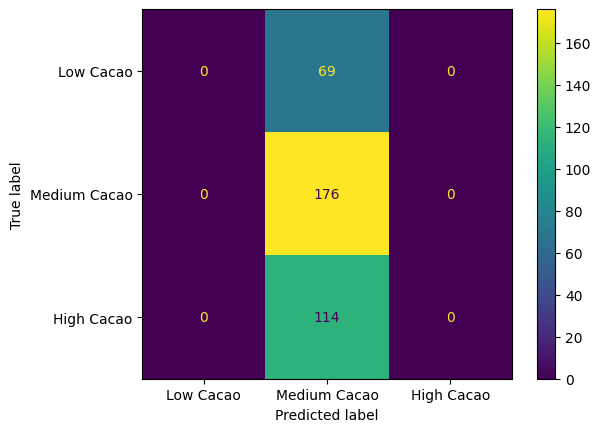

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

#predict class labels
Y_prob = model.predict(X_test)
Y_pred = np.argmax(Y_prob, axis=1)

#confusion matrix
confmat = confusion_matrix(Y_test, Y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=["Low Cacao","Medium Cacao","High Cacao"])
display.plot()

#compute precision and recall per class
precision = precision_score(Y_test, Y_pred, average=None)
recall = recall_score(Y_test, Y_pred, average=None)

classes = ["Low Cacao","Medium Cacao","High Cacao"]

#identify lowest precision
lowest_precision_idx = np.argmin(precision)
print(f"Lowest precision: {classes[lowest_precision_idx]} = {precision[lowest_precision_idx]:.2f}")
# Largest source of false positives = sum of that column minus diagonal
fp = confmat[:, lowest_precision_idx].sum() - confmat[lowest_precision_idx, lowest_precision_idx]
print(f"Largest source of false positives for {classes[lowest_precision_idx]}: {fp} samples")

#identify lowest recall
lowest_recall_idx = np.argmin(recall)
print(f"Lowest recall: {classes[lowest_recall_idx]} = {recall[lowest_recall_idx]:.2f}")
#largest source of false negatives = sum of that row minus diagonal
fn = confmat[lowest_recall_idx, :].sum() - confmat[lowest_recall_idx, lowest_recall_idx]
print(f"Largest source of false negatives for {classes[lowest_recall_idx]}: {fn} samples")

#identify most confused class
#find largest off-diagonal value
off_diag = confmat.copy()
np.fill_diagonal(off_diag, 0)
most_confused_idx = np.unravel_index(np.argmax(off_diag), off_diag.shape)
print(f"Most confusion: {classes[most_confused_idx[0]]} misclassified as {classes[most_confused_idx[1]]}, count = {off_diag[most_confused_idx]}")

